In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [2]:
import numpy,random
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})


# null hypothesis is a single source - Gaussian 
mu_H0 = 0
sigma_H0 = 1

# alt hypothesis is 2 sources  - 2 Gaussians 
dmu =  1.01
def mu_1_H1():
  return mu_H0+dmu
def mu_2_H1():
  return mu_H0-dmu


In [3]:
n_events = 100000

def mc_1G(n_events):
    x=norm.rvs(mu_H0,sigma_H0,size=n_events)
    return x

def mc_2G(n_events):
    mu_1_H1 = mu_H0+dmu
    mu_2_H1 = mu_H0-dmu
    #x1=norm.rvs(mu_1_H1,sigma_H0,size=int(n_events/2))
    #x2=norm.rvs(mu_2_H1,sigma_H0,size=int(n_events/2))
    # randomly choose between each of the two gaussians 
    xs = []
    for i in range(n_events):
        r = numpy.random.uniform(0,1)
        if  r > 0.5: xs.append(norm.rvs(mu_2_H1,sigma_H0,size=int(1))[0])
        else: xs.append(norm.rvs(mu_1_H1,sigma_H0,size=int(1))[0])
    
    return numpy.array(xs)

In [4]:
net = torch.nn.Sequential(
        torch.nn.Linear(1, 100),
        torch.nn.LeakyReLU(),
        #torch.nn.Dropout(p=0.8),
        torch.nn.Linear(100, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid()
    )

net.to(torch.double)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,weight_decay=0.0001)
loss_func = torch.nn.BCELoss() 

In [5]:
# make some data, should be from H0 and H1 
xH0 = mc_1G(n_events)
xH1 = mc_2G(n_events)
fH0 = [0 for xx in xH0]
fH1 = [1 for xx in xH1]

xH0 = torch.reshape(torch.from_numpy(numpy.array(xH0)).type(torch.double),(n_events,1))
xH1 = torch.reshape(torch.from_numpy(numpy.array(xH1)).type(torch.double),(n_events,1))

x = torch.from_numpy(numpy.concatenate([xH0,xH1])).type(torch.double)
f = torch.from_numpy(numpy.concatenate([fH0,fH1])).type(torch.double)

x = torch.reshape(x,(n_events*2,1))
f = torch.reshape(f,(n_events*2,1))


In [6]:
MAXSTEPS=100
step = 0

losses = []
#while MSE>0.1: #for t in range(n_epochs):
while step < MAXSTEPS:

    step+=1

    prediction = net(x)     # input x and predict based on x
    
    loss  = loss_func(prediction, f)     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    losses.append(loss)

In [7]:

#plt.plot(range(0,len(losses)),losses)

In [8]:
#print(x[0:10],net(x)[0:10])

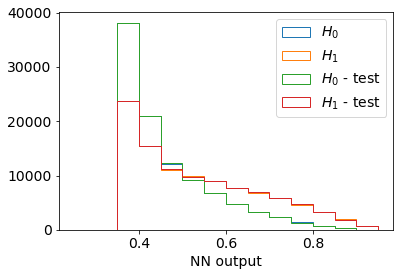

In [9]:
yH0 = net(xH0).detach().numpy()
yH1 = net(xH1).detach().numpy()

xH0_n = mc_1G(n_events)
xH1_n = mc_2G(n_events)

xH0_n = torch.reshape(torch.from_numpy(numpy.array(xH0_n)).type(torch.double),(n_events,1))
xH1_n = torch.reshape(torch.from_numpy(numpy.array(xH1_n)).type(torch.double),(n_events,1))


yH0_n = net(xH0_n).detach().numpy()
yH1_n = net(xH1_n).detach().numpy()

plt.hist(yH0,histtype='step',label="$H_{0}$",bins=numpy.arange(0.25,1,0.05))
plt.hist(yH1,histtype='step',label="$H_{1}$",bins=numpy.arange(0.25,1,0.05))
plt.hist(yH0_n,histtype='step',label="$H_{0}$ - test",bins=numpy.arange(0.25,1,0.05))
plt.hist(yH1_n,histtype='step',label="$H_{1}$ - test",bins=numpy.arange(0.25,1,0.05))
plt.xlabel("NN output")
plt.legend()
plt.savefig("nndist.pdf")

In [10]:
def nlogLR(data):
    LH0    = numpy.log(norm.pdf(data,mu_H0,sigma_H0))
    LH1    = numpy.log(0.5*(norm.pdf(data,mu_1_H1(),sigma_H0)+norm.pdf(data,mu_2_H1(),sigma_H0)))
    
    Lambda = sum(LH1-LH0)
    return -Lambda

# Distribution under H0 
n_samples = 5000
n_events = 1 
lHRH0 = []

for i in range(n_samples):
 xH0 = mc_1G(n_events)
 lHRH0.append(nlogLR(xH0))

lHRH1 = []
for i in range(n_samples):
 xH1 = mc_2G(n_events)
 lHRH1.append(nlogLR(xH1))


Text(0, 0.5, '$f(\\Delta q)$')

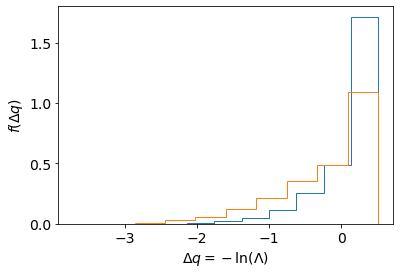

In [11]:
plt.hist(lHRH0,histtype='step',label="$H_{0}$",density=True)
plt.hist(lHRH1,histtype='step',label="$H_{1}$",density=True)
plt.xlabel("$\Delta q = -\ln(\Lambda)$")
plt.ylabel("$f(\Delta q)$")

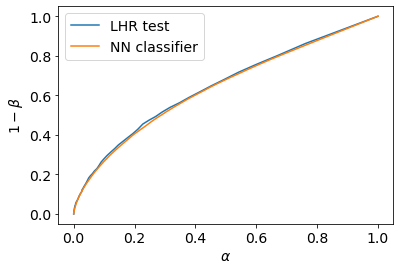

In [12]:
# make a plot of size vs power 

def size_and_power(tH0,tH1,which):
    xr = numpy.linspace(min([min(tH0),min(tH1)]),max([max(tH0),max(tH1)]),100)
    if which>0 : 
        ar = [len(list(filter(lambda k: k> xx,tH0)))/len(tH0) for xx in xr]
        pr = [len(list(filter(lambda k: k> xx,tH1)))/len(tH1) for xx in xr]
    else: 
        ar = [len(list(filter(lambda k: k< xx,tH0)))/len(tH0) for xx in xr]
        pr = [len(list(filter(lambda k: k< xx,tH1)))/len(tH1) for xx in xr]
    return (ar,pr)

arLH,prLH = size_and_power(lHRH0,lHRH1,-1)
arx,prx   = size_and_power(yH0,yH1,1)

plt.plot(arLH,prLH,label="LHR test")
plt.plot(arx,prx,label="NN classifier")
#plt.plot(arx,prx,label="NN classifier")
plt.xlabel("$\\alpha$")
plt.ylabel("$1-\\beta$")
plt.legend()
plt.savefig("classifier_vs_LHRT.pdf")

In [13]:
# Re-weight events based on f(x)=net

def weight(x):

    #x = torch.reshape([x],(1,1))
    x = torch.reshape(torch.from_numpy(numpy.array([x])).type(torch.double),(1,1))
    f = net(x)
    w = (f/(1-f))
    return w.detach().numpy()[0][0]



25000 25000


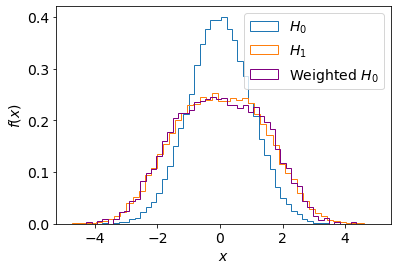

In [14]:
xH0 = mc_1G(5*n_samples)
xH1 = mc_2G(5*n_samples)

weights = []
for a in xH0: weights.append((weight(a)))

plt.hist(xH0,histtype='step',label="$H_{0}$",density=True,bins=50)
plt.hist(xH1,histtype='step',label="$H_{1}$",density=True,bins=50)
plt.hist(xH0,weights=weights,histtype='step',density=True,color='purple',bins=50,label="Weighted $H_{0}$")

print(len(xH0),len(xH1))
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
#plt.yscale('log')
plt.legend()

In [15]:
@numpy.vectorize
def weight_true(x):
    n = 0.5*(norm.pdf(x,mu_1_H1(),sigma_H0)+norm.pdf(x,mu_2_H1(),sigma_H0))
    d = norm.pdf(x,mu_H0,sigma_H0)
    return n/d

Text(0, 0.5, '$p(H_{1})/p(H_{0})$')

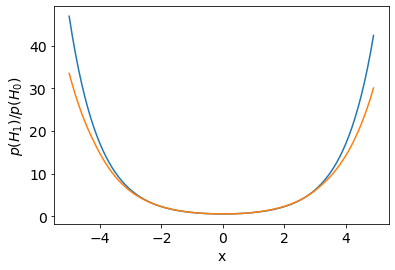

In [16]:
xsp = numpy.arange(-5,5,0.1)
plt.plot(xsp,weight_true(xsp))
plt.plot(xsp,[weight(xs) for xs in xsp])
plt.xlabel("x")
plt.ylabel("$p(H_{1})/p(H_{0})$")

In [54]:
# next the idea is to parameterize the thing and see if we can't learn the profile ratio
dmvals = [0,0.2,0.5,0.8,1,1.2,1.5,1.8,2,2.2,2.5,3]

In [55]:
import random

def mc_1G_2(n_events):
    x=norm.rvs(mu_H0,sigma_H0,size=n_events)
    xnew = [[xx,random.choice(dmvals)] for xx in x]
    return numpy.array(xnew)

def mc_2G_2(n_events,dmu):
    mu_1_H1 = mu_H0+dmu
    mu_2_H1 = mu_H0-dmu
    
    xs = []
    for i in range(n_events):
        r = numpy.random.uniform(0,1)
        if  r > 0.5: xs.append([norm.rvs(mu_2_H1,sigma_H0,size=int(1))[0],dmu])
        else: xs.append([norm.rvs(mu_1_H1,sigma_H0,size=int(1))[0],dmu])
    
    return numpy.array(xs)

In [56]:
# step 1 is to pick several values of delta_mu, our training samples will be those ones 
n_events=1000

# make some data, should be from H0 and H1 
xH0 = mc_1G_2(len(dmvals)*n_events)
xH1 = mc_2G_2(n_events,dmvals[0])
for dm in dmvals[1:]:
    res = mc_2G_2(n_events,dm)
    xH1 = numpy.concatenate((xH1,res))

fH0 = [0 for xx in xH0]
fH1 = [1 for xx in xH1]


#xH0 = torch.reshape(torch.from_numpy(numpy.array(xH0)).type(torch.double),(len(dmvals)*n_events,2))
#xH1 = torch.reshape(torch.from_numpy(numpy.array(xH1)).type(torch.double),(len(dmvals)*n_events,2))

x = torch.from_numpy(numpy.concatenate([xH0,xH1]))
f = torch.from_numpy(numpy.concatenate([fH0,fH1]))


x = torch.reshape(x,(len(dmvals)*n_events*2,2)).type(torch.double)
f = torch.reshape(f,(len(dmvals)*n_events*2,1)).type(torch.double)

In [57]:
net2 = torch.nn.Sequential(
        torch.nn.Linear(2, 500),
        torch.nn.LeakyReLU(),
        #torch.nn.Dropout(p=0.8),
        torch.nn.Linear(500, 200),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 20),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid()
    )

net2.to(torch.double)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,weight_decay=0.0001)
loss_func = torch.nn.BCELoss() 

In [ ]:
MAXSTEPS=500
step = 0

losses = []
#while MSE>0.1: #for t in range(n_epochs):
print(len(net2(x)))
while step < MAXSTEPS:

    step+=1

    prediction = net2(x)     # input x and predict based on x
    
    loss  = loss_func(prediction, f)     # must be (1. nn output, 2. target)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    losses.append(loss)

24000


In [ ]:
def qLR(x,dm):
    # this should now be the qLR function 
    x = torch.reshape(torch.from_numpy(numpy.array([ [xx,dm] for xx in x])).type(torch.double),(len(x),2))
    f = net2(x)
    z = f/(1-f)
    z = z.detach().numpy()
    return (-2*sum(numpy.log(z)))[0]

print(qLR([5,3,2],0.3))

In [ ]:
def mc_2G_3(n_events,dmu):
    mu_1_H1 = mu_H0+dmu
    mu_2_H1 = mu_H0-dmu
    
    xs = []
    for i in range(n_events):
        r = numpy.random.uniform(0,1)
        if  r > 0.5: xs.append(norm.rvs(mu_2_H1,sigma_H0,size=int(1))[0])
        else: xs.append(norm.rvs(mu_1_H1,sigma_H0,size=int(1))[0])
    
    return numpy.array(xs)

In [ ]:
# now invent some data 
data = mc_2G_3(100,1.4)
plt.hist(data,20)

In [ ]:
def mu_1_H1_p(dmu):
  return mu_H0+dmu
def mu_2_H1_p(dmu):
  return mu_H0-dmu

In [ ]:
# now we can do the usual ratio, lets plot it 
def normalqLR(xx,dm):
    z = []
    for x in xx: 
      n = 0.5*(norm.pdf(x,mu_1_H1_p(dm),sigma_H0)+norm.pdf(x,mu_2_H1_p(dm),sigma_H0))
      d = norm.pdf(x,mu_H0,sigma_H0)    
      z.append(n/d) 
    return -2*sum(numpy.log(z))

In [ ]:
print(normalqLR(data,0.4))

In [ ]:
dmrange = numpy.linspace(0.1,3,100)
plt.plot(dmrange,[normalqLR(data,dm) for dm in dmrange])
plt.plot(dmrange,[qLR(data,dm) for dm in dmrange])